# Assignment 1
### By Brian Coari, Stephen Merritt, Cory Thigpen, and Quentin Thomas

In [1]:
%%time
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
results = []
names = []
scoring = 'f1_weighted'

models = []
models.append(('Logistic Regression', lr_clf))
models.append(('KNN', knn))
models.append(('Random Forest', rf))



for name, model in models:
    cv_results = cross_val_score(model, X_train_task2, y_train_task2, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.2f (%.5f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


clf_labels = ['Logistic Regression', 'KNN','Random Forest']

# boxplot algorithm comparison
fig = plt.figure(figsize=(12, 7))
fig.suptitle('Algorithm F1 Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(clf_labels)
plt.show()

NameError: name 'lr_clf' is not defined

## Olympics
---

## Business Understanding
---

For our dataset this semester we selected the ["120 years of Olympic history: athletes and results"](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) dataset from Kaggle. This dataset tracks all Olympians' medal results from 1896-2016, as well as various physical attributes such as `gender`, `age`, `weight`, and `height`. This dataset was originally collected for various analyses, such as whether host countries' athletes win more medals, and to track the involvement of women in the Olympics from various countries over time.

Our intent this semester is to focus on analyzing the physical attributes of the Olympians over time, when they are available. We would like to determine the trends around `age`, `height`, and `weight` in sports over time, and whether they seem to be trending to some kind of "ideal ratio" for each sport. We would like to predict what the body types will look like in the next Olympic games, and in the Olympic games 120 years out from now, given the current data available. For this analysis we are eliminating linear regression as a viable option, since any non-zero slope would trend to positive or negative infinity, and long-term extrapolation would quickly become absurd. We will attempt quadratic, exponential, and logarithmic regression in order to derive meaningful insights from the data. To consider our analysis "successful", our target is to explain at least 80% of the variablity in the data with our regression model, and for the 120-year prediction of `height` and `weight` to be within the realm of possibility given existing human means and standard deviations for body types.  

We would also like to see how these ratios compare to the average person in order to see which Olympic sports might be the most accessible from a body size perspective.

Finally, we would like to analyze our team members' own body types and see for which Olympic sports we might be best-suited, strictly from a `height` and `weight` perspective.

## Data Meaning Type
---

A full description of the original dataset can be found [here](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home), we are focusing only on the relevant and non-reduntant fields for our analysis.

This dataset (athlete_events.csv) contains 271,116 rows. Each row corresponds to an individual athlete competing in an individual Olympic event. The columns are:

`ID` (Integer) - A unique number for each athlete

`Name` (String) - The athlete's name.

`Sex` (Character) - The gender of the athlete, currently either "M" or "F" in this dataset.

`Age` (Integer) - The age of the athlete.

`Height` (Integer) - The height of the athlete in centimeters.

`Weight` (Integer) - The weight of the athlete in kilograms.

`Team` (String) - The team (mainly the country) for which the athlete is participating.

`Year` (Integer) - The year of Olympic games, ranging from 1896-2016 in this dataset.

`Season` (String) - The season of Olympic Games, either "Summer" or "Winter".

`City` (String) - The host city of Olympic Games.

`Sport` (String) - The sport in which the Athlete competed.

`Event` (String) - The event in which the Athlete competed.

`Medal` (String) - The medal obtained by the athlete for this row's data, "Gold", "Silver", "Bronze", or "NA".

About 89% of the rows are missing data in at least one of these columns. This is due to records not being kept that far back in history, or for specific sports. For sports that did not track `height` and `weight` at all, we will exclude these from our analysis. For other sports that just contain missing data for some athletes we will run our analysis both by dropping the records entirely and by imputing the values using the mean for the population we are analyzing. Both of these approaches have pros and cons and we will target the approach that yields maximum statistical benefit.


## Data Quality
---

The following feautre have signficant NA values that must be handled prior to further analysis.

* `Age`
* `Height`
* `Weight`
* `Medal`

The first area of concern with the overall quality of the data is the number of NAs for the `height` and `weight` features (22.19% and 23.19% respectively). This is exacerbated by the fact that a simple mean value imputation will not provide a holistic solution since mean `height` and `weight` values vary significantly per sport.  For example the mean `height` for an Olympic Male Basketball player is going to be extremely different from the mean `height` of a female gymnast. For this reason, we decided to impute the the `height`, and `weight` following groupby operations via `sport` and `sex`. `Age` (3.49% NA) also had similar imputation issues, so the same method was applied to the `age` feature. The most populous NA feature is `medal` (85.33%), however its solution is the simplest. It can safely be assumed that this is not a mistake since there are three medals awarded per event per Olympics, so a large percentage of NA values in this column is expcected. NAs in this column were replaced with the string **'No Medal'**. 

#### Package Import

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import re
import xlwt
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', DeprecationWarning)

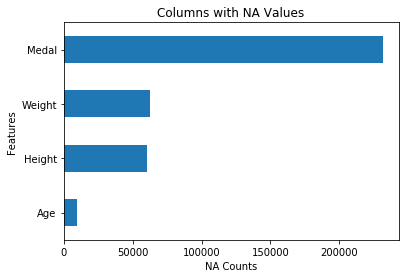

In [3]:
df = pd.read_csv('data/athlete_events.csv')
ax = df[['Age', 'Height', 'Weight', 'Medal']].isnull().sum().plot(kind = 'barh')
ax.set_title("Columns with NA Values")
ax.set_xlabel("NA Counts")
ax.set_ylabel("Features")
plt.show()

In [4]:
agena = (df['Age'].isnull().sum()/len(df['Age'])) * 100
heightna = (df['Height'].isnull().sum()/len(df['Height'])) * 100
weightna = (df['Weight'].isnull().sum()/len(df['Height'])) * 100
medalna = (df['Medal'].isnull().sum()/len(df['Medal'])) * 100
print('Weight NA percentage: %.2f' % (agena) + '%')
print('Height NA percentage: %.2f' % (heightna) + '%')
print('Weight NA percentage: %.2f' % (weightna) + '%')
print('Medal NA percentage: %.2f' % (medalna) + '%')

Weight NA percentage: 3.49%
Height NA percentage: 22.19%
Weight NA percentage: 23.19%
Medal NA percentage: 85.33%


In [5]:
# Fill all Medal NAs with 'No Medal'
df.Medal = df.Medal.fillna('No Medal')
#list of sports with no Height/Weight listed and competed since 1936
oldsports = ['Aeronautics', 'Alpinism', 'Art Competitions','Basque Pelota', 'Cricket', 'Croquet', 'Jeu De Paume','Military Ski Patrol',
             'Motorboating','Polo', 'Racquets', 'Roque']
df1 = df[df['Sport'].isin(oldsports)]
grouped = df1.groupby('Sport')
groupedyear = grouped['Year']
groupedyear = pd.DataFrame(groupedyear.agg('max'))
print(groupedyear)
df['Sport'].value_counts()
#drop the 611 observations containing these sports
df = df.drop(df[df.Sport.isin(oldsports)].index)
# Impute NA values by Sex and Sport
df.Height = df.groupby(['Sex', 'Sport'])['Height'].apply(lambda x: x.fillna(x.mean()))
df.Weight = df.groupby(['Sex', 'Sport'])['Weight'].apply(lambda x: x.fillna(x.mean()))
df.Age = df.groupby(['Sex', 'Sport'])['Age'].apply(lambda x: x.fillna(x.mean()))

                     Year
Sport                    
Aeronautics          1936
Alpinism             1936
Art Competitions     1948
Basque Pelota        1900
Cricket              1900
Croquet              1900
Jeu De Paume         1908
Military Ski Patrol  1924
Motorboating         1908
Polo                 1936
Racquets             1908
Roque                1904


**Further NA discussion:**
Upon review of the remaining NAs following the groupby and imputation operations, 12 sports were found to have no data on any athletes for either `height`, `weight`, or `age`.  These sports accounted for 611 observations, a mere 0.22% of the data.  Further investigation showed that these sports had not been played in the Olympics since 1948.  The decision was made to drop these observations from future analysis.  The list of sports can be found in the object: *oldsports*.  As can be seen below, there were no further NA values remaining in the dataset.  A definition for a few of these sports can be found below and provides a clearer understanding as to why these observations have been omitted.
* [Art Competitions](https://en.wikipedia.org/wiki/Art_competitions_at_the_Summer_Olympics) - Medals were awarded for works of art inspired by sport, divided into five categories: architecture, literature, music, painting, and sculpture.  Art competitions were abandoned because artists were considered to be professionals, while Olympic athletes were required to be amateurs.
* [Alpinism](https://www.sports-reference.com/olympics/winter/1924/ALP/) - Medals were awarded to the individual or group that had achieved the most notable feat in mountaineering since the previous Games!  The first medals were awarded to members of the unsuccessful 1922 British expedition to Mt. Everest. This included seven posthumous medals for those who had died!  The final two medals were awarded in 1936.
* [Motorboating](https://en.wikipedia.org/wiki/Water_motorsports_at_the_1908_Summer_Olympics) - Each event included 5 laps around an 8 mile course.  In 1908, only one boat finished and the International Olympic Committee (IOC) later deemed the sport non-Olympic! ![alt text](https://upload.wikimedia.org/wikipedia/commons/e/e0/1908_Wolseley-Siddely.JPG)

In [6]:
df.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

In [7]:
unique_teams = df.Team.unique()
# Horse names used in Team column for Equestrian Events
print(unique_teams)
dfregions = pd.read_csv('data/noc_regions.csv')
# Merge athletes and regions dataframes to clean country names
df = pd.merge(left = dfregions, right = df, how = 'left', on=['NOC'], left_index=True)

['China' 'Denmark' 'Denmark/Sweden' ... 'Solos Carex' 'Dow Jones' 'Digby']


**Team Names**

A review of the `team` feature revealed that most team names matched the country for whom the athlete competed, except in the Equestrian events. The team name for Equestrian events appeared to be linked to a horse's name.  To rectify this, the decision was made to merge data from the *noc_regions.csv* file with the exisiting df dataframe, and rename the `region` feature `country`. When this merge was completed the country names for **TUV** and **ROT** were found in the `notes` feature, which is later dropped creating NA values in the `country` column.  The NAs were replaced with **Tuvula** and **Refugee Athlete**. 

In [8]:
df.rename(index = str, columns = {'region' : 'Country'}, inplace = True)
df = df.drop(columns = ['notes'])
#Replace NA values in Country column with Tuvula and Refugee Athlete
df['Country'] = np.where(df['NOC'] == 'TUV', 'Tuvala', df['Country'])
df['Country'] = np.where(df['NOC'] == 'ROT', 'Refugee Athlete', df['Country'])
df = df.drop(df[df['NOC'] == 'UNK'].index)

df['Year'] = df['Year'].astype(int)
df['Height'] = df['Height'].astype(int)
df['Weight'] = df['Weight'].astype(int)
df['Age'] = df['Age'].astype(int)

In [9]:
unique_countries = df.Country.unique()
print(len(unique_countries))

207


**Country Names**

There are 208 unqiue country names listed in the dataset.  The site [worldometers](http://www.worldometers.info/geography/how-many-countries-are-there-in-the-world/) lists 195 unique country names.  This disparity is due to the large number of country-owned territories that are not officially recognized.  For example, people from the Island of Guam, a US territory, can compete for **Guam** in the Olympics even though Guam is not officially recognized as a country.  A handful of athletes also compete as refugees, which adds to the `country` totals. It is safe to assume that the remaining country names are valid.

In [10]:
#Extract 'Event' Men's/Women's from the Event Column
df['Event'] = df['Event'].str.replace("(\w+\s+\w+\'s)", '')
df.to_csv('data/athletes_cleaned_merged.csv')

**Event feature cleaning**

The `event` feature had repeat information that can be found in other columns (ex. **Basketball Men's Basketball**). For brevity, this was shortened with a regular expression to remove the words preceding an apostrophe `s`. Now the `event` column just reads **Basketball** or **100 metres Butterfly**. 

**Outliers**

The three quantitative features `age`, `height`, and `weight` were verified for outliers.  Initial research into past Olympians yielded the following upper and lower bounds:

* Oldest Olympian: **72 Years Old**
* Youngest Olympian: **10 Years 8 Months**
* Tallest Olympian: **226 (cm)**
* Shortest Olympian: **127 (cm)**
* Heaviest Olympian: **214 (kg)**
* Lightest Olympian: **25 (kg)**

So, while these indivdiuals certainly stand out, even from other Olympic athletes, the observations are valid and will rew `weight` and `age` are both right skewed with some outliers in the tails. As expected Male athletes on average are taller and heavier than female athletes, while the `age` distribution is nearly identical for both genders.

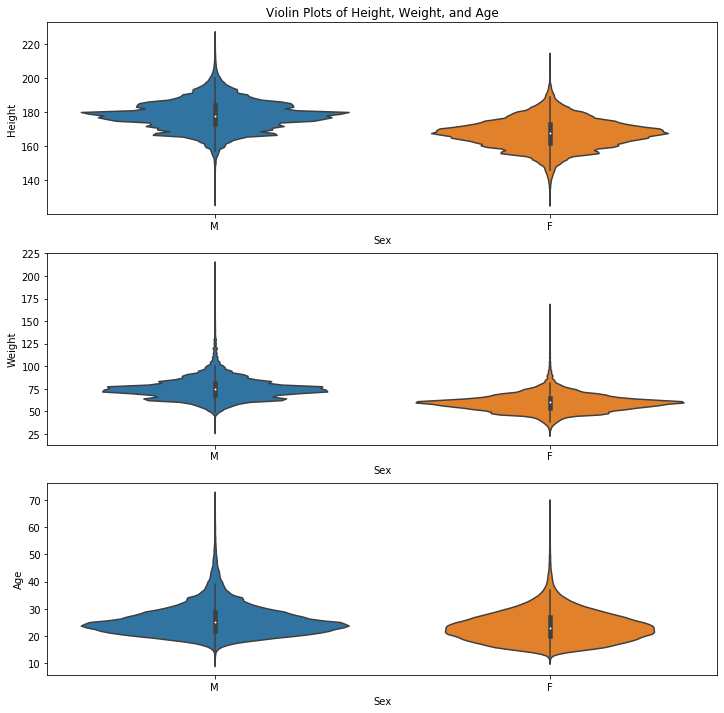

In [11]:
oldolympians = pd.DataFrame(df[df.Age >= 72])
youngolympians = pd.DataFrame(df[df.Age <= 11])
tallestolympians = pd.DataFrame(df[df.Height >= 220])
shortestolympians = pd.DataFrame(df[df.Height <= 130])
heaviestolympians = pd.DataFrame(df[df.Weight >= 200])
lightestolympians = pd.DataFrame(df[df.Weight <= 25])
plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 1)
sns.violinplot(x = 'Sex', y = 'Height', data = df)
plt.title('Violin Plots of Height, Weight, and Age')
plt.subplot(3, 1, 2)
sns.violinplot(x = 'Sex', y = 'Weight', data = df,)
plt.subplot(3, 1, 3)
sns.violinplot(x = 'Sex', y = 'Age', data = df)

## Simple Statistics
---


In this section we will start to look at the features of our data to form thoughts on the basic shape of the data. We will look at a few rows, then the mins, maxes, means, and medians of our relevant features, and run an analysis of those values over time to see any basic trends.

In [12]:
# now lets look at the first five records of data
df.head()

,NOC,Country,ID,Name,Sex,Age,Height,Weight,Team,Games,Year,Season,City,Sport,Event,Medal
872,AFG,Afghanistan,502.0,Ahmad Shah Abouwi,M,25,176,73,Afghanistan,1956 Summer,1956,Summer,Melbourne,Hockey,Hockey,No Medal
1950,AFG,Afghanistan,1076.0,Jammal-ud-Din Affendi,M,28,176,73,Afghanistan,1936 Summer,1936,Summer,Berlin,Hockey,Hockey,No Medal
1992,AFG,Afghanistan,1101.0,Mohammad Anwar Afzal,M,23,177,73,Afghanistan,1948 Summer,1948,Summer,London,Football,Football,No Medal
3129,AFG,Afghanistan,1745.0,Mohammad Aktar,M,17,156,48,Afghanistan,1980 Summer,1980,Summer,Moskva,Wrestling,"Light-Flyweight, Freestyle",No Medal
8410,AFG,Afghanistan,4628.0,Mohammad Daoud Anwary,M,22,172,76,Afghanistan,1964 Summer,1964,Summer,Tokyo,Wrestling,"Bantamweight, Freestyle",No Medal


In [13]:
#Let's group like features together into continuous, ordinal, and categorical features
df.Year = df.Year.astype(int)
continuous_features = ['Height', 'Weight']
ordinal_features = ['Age']
categ_features = ['ID','Name','Sex','Country','Year','NOC','Games','City','Sport','Event','Medal']

In [14]:
#run basic summary of continuous and ordinal features
df[continuous_features+ordinal_features].describe()

,Height,Weight,Age
count,266954.000000,266954.000000,266954.000000
mean,175.420964,71.017449,25.330184
std,9.868955,13.331096,5.801643
min,127.000000,25.000000,10.000000
25%,169.000000,62.000000,21.000000
50%,176.000000,71.000000,24.000000
75%,182.000000,78.000000,28.000000
max,226.000000,214.000000,72.000000


In [15]:
#calculate the median for continuous and ordinal features
df[continuous_features+ordinal_features].median()

Height    176.0
Weight     71.0
Age        24.0
dtype: float64

The `heights` of the Olympians in our population range from 127-226 cm with a mean of 175.54 cm and a median of 176 cm.

The `weights` of the Olympians in our population range from 25-214 kg with a mean of 71.13 kg and a median of 71 kg.

The `ages` of the Olympians in our population range from 10-72 years old with a mean of 25.34 years old and a median of 24.65 years old.


In [16]:
#Separate into two categories, greater than the mean year or less than the mean year, to see any stark differences
df[continuous_features+ordinal_features].groupby(by=df.Year>df['Year'].mean()).mean()

,Height,Weight,Age
Year,,,
False,174.990055,71.155237,25.614709
True,175.722031,70.921179,25.131393


From the means before and after the mean year for the dataset we can see that the `height` of Olympians in the second half of the dataset seem to be slightly higher, while `weight` and `age` seem to be slightly lower, on average. 

Text(0, 0.5, 'Count')

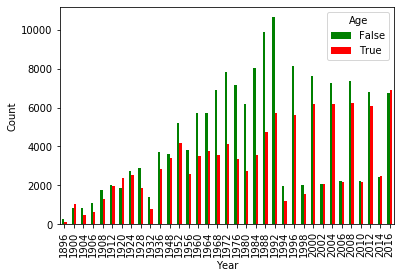

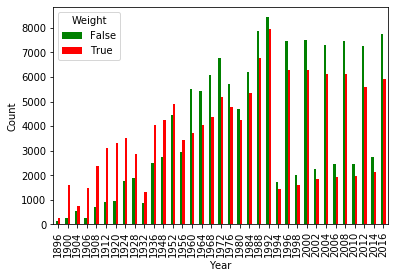

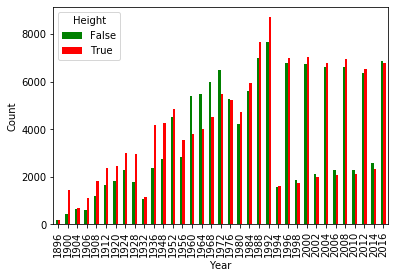

In [17]:
#plot charts of age, weight, and height over time against their means
age_over_mean = pd.crosstab([df['Year']], df.Age>df['Age'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

age_over_mean = pd.crosstab([df['Year']], df.Weight>df['Weight'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

age_over_mean = pd.crosstab([df['Year']], df.Height>df['Height'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

In the plots above we can see that for a period of 40 years from 1952-1992 the ages of athletes was steadily decreasing and were trending well below the mean `age` for our population. After 1992 until 2016 the `ages` of athletes started reversing that trend, getting older until in 2016 there was about an even split. 

For `weights` of athletes we see a general trend of olympians getting lighter over time. there was a period of stabilization where the `weights` seemed to be getting closer to the mean `weight` for our population, but then up to 2016 the `weight` decreased again to have a trend of `weights` of Olympians below the mean.

`Heights` of olympians are very interesting. At the start of our timeline athletes were almost entirely above the mean `height` for our population. For a brief period between 1960 and 1972 Olympians were, in general, notably shorter than the mean `height` for our population, then that trend reversed from 1980-1992, when Olympians were mostly taller than the mean, then returning close to the mean by 2016.

## Visualize Attributes
---


**Points of interest**

Our Olympic data covers information that spans the years 1896 all the way to 2016. This offers us a wealth of information in regards to how well athletes did during this time. There are several interesting questions we chose to answer in order to help us understand this dataset more. The questions are: 

- What event awarded the most gold medals in the historical olympic data?
- What does the olympic participation by age group look like?
- Who are the top ten repeat olympic gold medalist of all time?
- Who are the top ten repeat Olympians unable to win any medal at all?
- Has the amount of summer olympic gold medals acheived by athletes increased over the years?

We begin to visualize and answer these questions next.

#### What event awarded the most gold medals in the historical Olympic data?


In [18]:

medal_count_by_event = df[df['Medal'] == 'Gold'].groupby(['Event'])['Medal'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'Gold Medals awarded by Event From 1896 to 2016')

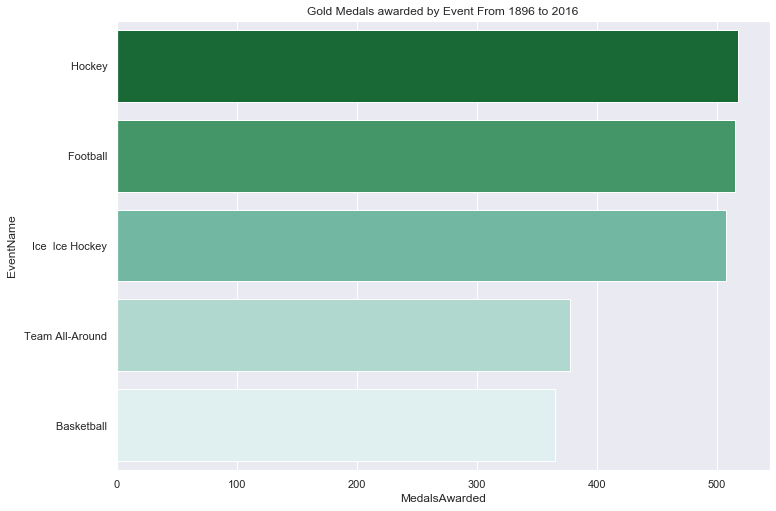

In [19]:
data_of_interest = medal_count_by_event[0:5]
chartdata = pd.DataFrame({'EventName': data_of_interest.index,
                         'MedalsAwarded': data_of_interest.values})
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot('MedalsAwarded', y='EventName', data=chartdata, 
            palette='BuGn_r', orient="h").set_title("Gold Medals awarded by Event From 1896 to 2016")

We can see from the chart above Hockey has had the most awarded Gold Medals between the years of 1896 to 2016. However, visually there does not appear to be that much of a difference between Ice Hockey and Football. Those two events seem to be separated by only a few medals. If medal prediction is our goal here it is useful to know which event saw the most Gold Medal activity.

#### What does the olympic participation by age group look like?

We know the ages of all the athletes to participate in the olympics. We decided that it would be interesting to know what the participation in the olympics looks like visualized by `age` group.

In [20]:
count_by_age = df.groupby(['Age', 'Season'])['Age'].count()
age_group_df = df[['Season', 'Age']].groupby(['Season','Age']).count().reset_index()
age_group_df['TimesAgeParticipated'] = count_by_age.values

In [21]:
def form_age_group(age):
    if age >= 10 and age <= 20:
        return 'Ages 10 to 20'
    elif age >= 21 and age <= 30:
        return 'Ages 21 to 30'
    elif age >= 31 and age <= 40:
        return 'Ages 31 to 40'
    else:
        return 'Ages 41 and Older'
    
age_group_df['AgeGroup'] = age_group_df['Age'].apply(form_age_group)

Text(0.5, 1.0, 'Olympic Participation Numbers By Agegroup From 1896 to 2016')

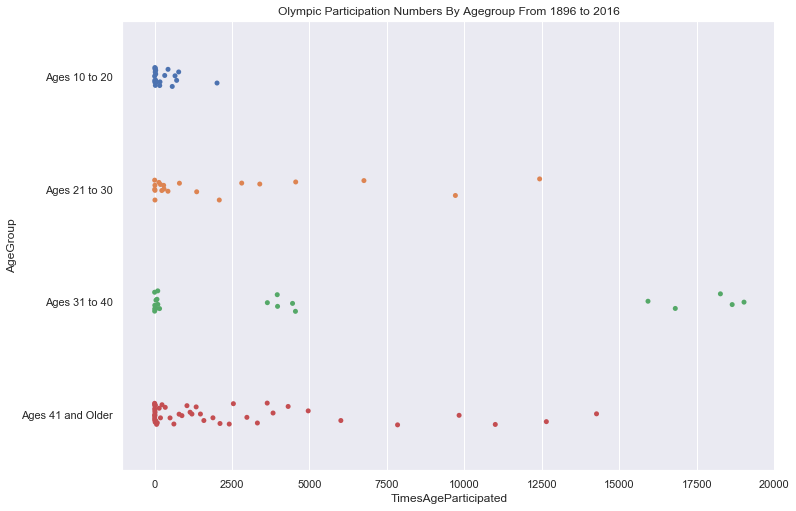

In [22]:
sns.stripplot(x="TimesAgeParticipated", y="AgeGroup", data=age_group_df, orient='h')
plt.title('Olympic Participation Numbers By Agegroup From 1896 to 2016')

The chart above gives us an idea of the different `age` groups we have participating in our Olympic data. We have divided our data into 4 `age` groups and counted the number of athletes that were at that specific `age` when they participated in the Olympics. These frequencies are illustrated with the points on the chart to show how common it was to have participants enter the games at their specific `ages`. On the left side of the chart we expect to see larger clusters for all groups which indicates the most common times these `age` groups are seen is somwhere between 1 and 5000 throughout all the Olympic historical data. However, what is shocking about this is `age` group **41 and Older** has somewhat of a wider spread toward the right side of the chart. This was suprising, as it shows that it is not uncommon to see older athletes in this dataset.

#### Who are the top ten repeat olympic gold medalist of all time?

Text(0.5, 1.0, 'Top 10 Olympic Gold Medalist from 1896 to 2016.')

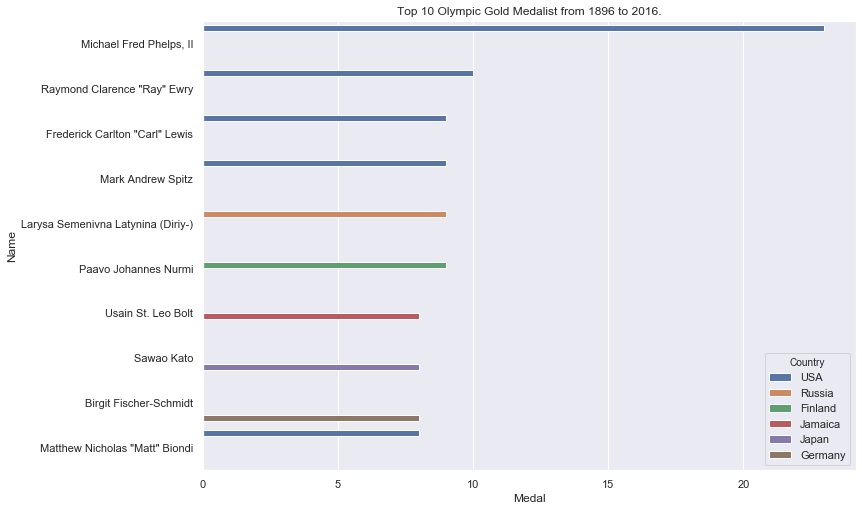

In [23]:
athelete_gold_medal_appearances = df[df['Medal'] == 'Gold'].groupby(['Name', 'Country'])['Medal'].count()
athlete_appearance_df  = athelete_gold_medal_appearances.reset_index()
top_ten_df = athlete_appearance_df[athlete_appearance_df['Medal'] > 1].sort_values(ascending=False, by='Medal')[0:10]

sns.barplot(x="Medal", y="Name", hue="Country", data=top_ten_df)
plt.title("Top 10 Olympic Gold Medalist from 1896 to 2016.")

The chart above finds all repeat Olympic athletes who have won `Gold`. Our interest is to examine the top ten Olympic athletes and sort them by the amount of gold medals that they won. This chart examines all records that covers the years 1896 to 2016. We can see that `Michael Phelps` is way ahead of the competition in that the closes second has won **10** gold medals! Whats also interesting is the United States has the most athletes represented on this chart making up 60% of the top ten atheletes on the chart.

#### Who are the top ten repeat Olympians unable to win any medal at all?


Text(0.5, 1.0, 'Top 10 Repeat Athlete In events without winning medals from 1896 to 2016.')

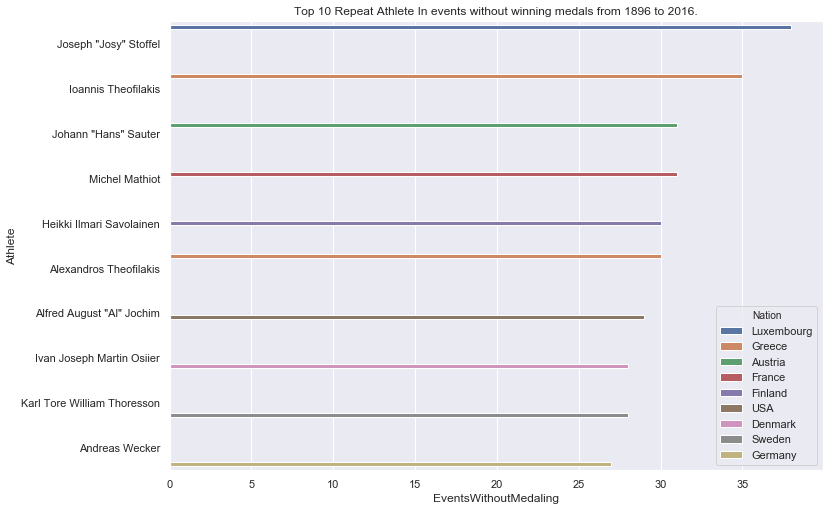

In [24]:
no_medal_atheletes = df[df['Medal'] == 'No Medal'].groupby(['Name', 'Country'])['Medal'].count()
multiple_appearnaces = no_medal_atheletes.reset_index()
multiple_appearnaces.columns = ['Athlete', 'Nation', 'EventsWithoutMedaling']
madf = multiple_appearnaces[multiple_appearnaces['EventsWithoutMedaling'] > 1].sort_values(ascending=False, by="EventsWithoutMedaling")

sns.barplot(x="EventsWithoutMedaling", y="Athlete", hue="Nation", data=madf[0:10])
plt.title("Top 10 Repeat Athlete In events without winning medals from 1896 to 2016.")

No athlete would want to be on the chart above, especially for something as big as the Olympics. We examine all the atheltes in our dataset that made multiple Olympic appearances, and counted the number of times those athletes returned home without medals. Unfortunately, [Joseph Stoffel of Luxemburg](https://www.flickr.com/photos/pitschspics/15318233086/in/album-72157647563921759/) makes the top of this list with more than 35 Olympic appearances and return flights home with absolutely nothing. Its also interesting to note that this chart is not dominated by one country like the top ten Olympic gold medalist chart is dominated by the `United States`.

#### Has the amount of summer olympic gold medals acheived by athletes increased over the years?

Text(0.5, 1.0, 'Awarded Summer Olympic Gold Medals overtime')

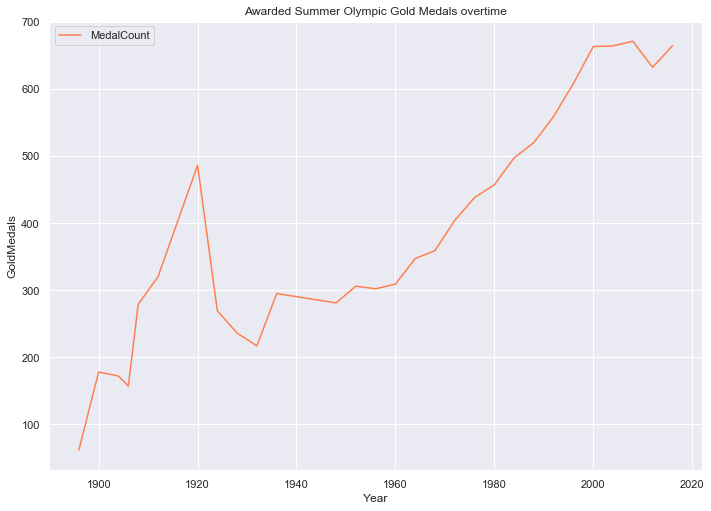

In [25]:
year_info = df[(df['Medal'] == 'Gold') & (df['Season'] == "Summer")].groupby(['Year'])['Medal'].count()
year_df = pd.DataFrame({'Year': year_info.index,
                       'GoldMedals': year_info.values})
sns.lineplot(x=year_df['Year'], y=year_df['GoldMedals'], color="coral", label="MedalCount")
plt.title('Awarded Summer Olympic Gold Medals overtime')

The chart above tracks the way the The awarding of gold medals have been moving over time. Our dataset begins in 1896 and we have entries all the way until 2016. What is really interesting here is that the pattern starts a smooth upward trajectory right around 1940. Right before the 2000 Olympics, a plateau starts to develop where you see the winnings peak for gold medals. It will be interesting to see how the coming years change the trajectory of the chart.  We can conclude that based on this chart, Gold medals have become more difficult to obtain between 2000 and 2016 and might have peaked.  Could this be due to more events being added, or increased competition?

## Explore Joint Attributes

---

#### Age, Weight, and Height, and the relationship to Gender

In order to get a good idea of the relationship between variables we examine a scatter plot of our quantitative variables. In our olympic dataset the quantitative variables of interest are of course `Age`, `Weight` and `Height`. We view the relationship of the variables by `Gender`.


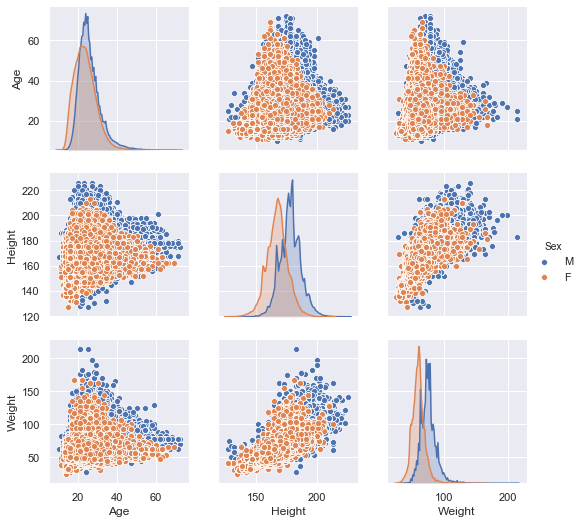

In [26]:
sns.pairplot(df,
             vars=['Age', 'Height', 'Weight'],
             hue='Sex', height=2.5)

We examine a pair scatter plot above to get a good idea of what the `age`, `weight`, and `height` look like for our athletes. Men and women have different builds as well as body types so it was neccessary to separate the two groups by the `Sex` variable. What we found interesting here is  how closely the shape of the data matches regardless of gender.

Take `age` and its relationship with `weight` on the bottom left of the chart. If we look at the bulk of the clustering, men and women both appear to take the same form. An even better view is the spread of the `weight` on the far right of the bottom row. There is a slight shift to the right for men while women have a slight shift to the left. This suggest that the difference in `weight` spread might not be something we can ignore with this variable when we proceed to modeling. 

The Males have higher peaks on their distributions for `age`, `weight`, and `height`. However, the distribution shapes don't appear to diverge much between Genders as a whole. The only notable divergence is perhaps, `weight` and `height`, but even that is pretty close.

It is also important to note that `age` for Male has a higher peak than that of Female. The max athletic `age` for `women` seems to be around 60-years-old while the historical data has shown `men` that were almost 75-years-old.

We might need to use a much more specific and identifiable metrics like `BMI` in order to have a good idea of the significant differences between the athletes as it is not easy to tell the difference visually. If we where to remove the color coding for male and female it would look like all the data is from the same distribution in many of these quantitative catagories.

#### Which Team won the most olympic GOLD medals between from 1896 to 2016?

This dataset covers Olympic data all the way back to 1896. It would be interesting to find out how which team won the most gold medals regardless of the type of the Olympics whether it be `summer` or `winter`. The variables we will need to explore is `team` and `medal` counts.

In [27]:
won_gold = df['Medal'] == 'Gold'
gmc = df[won_gold].groupby(['Country'])['Medal'].count().sort_values(ascending=False)

In [28]:
gold_medal_counts = pd.DataFrame({'Country':gmc.index,
                                  'Gold Medals':gmc.values})

If we look at the Top ten gold medal winners for the Olympics we can see `United States` has historically won the most gold medals. `Russia` comes in second with `Germany` coming in third. To give a good idea of the counts visually, we use the chart below.

Text(0.5, 1.0, 'Olympic Gold Medal Totals From 1896 to 2016')

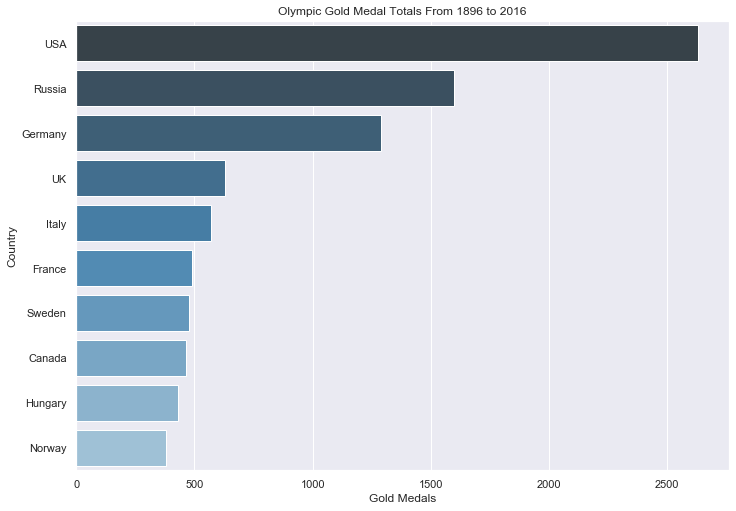

In [29]:
sns.barplot('Gold Medals', y='Country',
            data=gold_medal_counts.head(10), 
            palette='Blues_d', orient="h").set_title("Olympic Gold Medal Totals From 1896 to 2016")

We can see visually the top ten countries in our olympic data by the amount of gold medals won. This is significant as we can use this to understand the proportions of winning the gold medal by country. The model can use this information in order to successfully predict which medal was won based on the team varaible being included in the model.

#### Athletes BMI and its relationship to time

Another Joint relationship we wish to understand is how our athletes `Ages`, `Weight` and `Height` are related to our timeline. We saw earlier that there is an interesting pattern with the amount of gold medals awarded throughout all the years the Olympic data has been collected. It might also be a good idea for us to take a look at whether or not there is any correlation between time and our physical descripters of the athletes.

We can't view `Age`, `Weight`, and `Height` clustered together for all althletes so we will instead use the `BMI` as our metric. Our `BMI` will be calculated as..

$$
BMI = \left(\frac{\omega}{\eta \eta}\right) C
$$

where $\omega$ represents our athletes weight in kilograms, and $\eta$ represents our athletes height in centimeters, and $C$ is our constant at `10,000`.

Text(0.5, 1.0, 'Olympic Athelete BMI overtime 1896 to 2016')

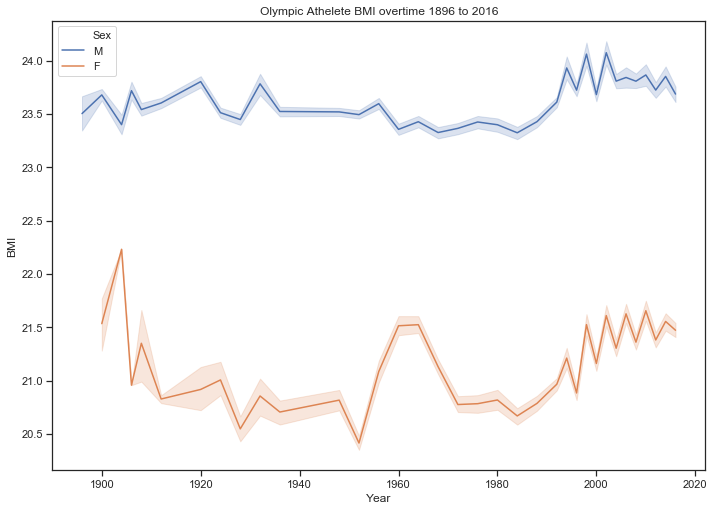

In [30]:
sns.set_style('ticks')

def calculate_bmi(df):
    return (df[1]/(df[0] * df[0])) * 10000

sub_data = df[['Year', 'Height', 'Weight','Age', 'Sex']].sort_values(ascending=True, by='Year')

sub_data['BMI'] = sub_data[['Height', 'Weight']].apply(calculate_bmi, axis=1)

sns.lineplot(x='Year', y='BMI', hue='Sex', data=sub_data)
plt.title('Olympic Athelete BMI overtime 1896 to 2016')

The chart above gives us a good example of how the `BMI` for Olympic athletes has fluctuated overtime. What is interesting to note is our range goes from a index of `20.5` and `24.0`. There is a notable difference in the `BMI` for `males` and `females`, so we visualize this change over time segmented by the two groups. The `males` have been steady as the years passed between the 1900 to 1980, however during the early 2000's we can see a slight uptick in the `BMI` of `male` athletes. This could indicate that modern athletes are getting a bit bigger than they were in the early 1900s. On the `female` side of the chart we can see the opposite trend. It looks as though the `females` have started out with a high `BMI`, but started to move away from the historical peak `BMI` in the early 1900's.  It would be interesting to see how the `BMI` changes over the next 20 years for both `sexes` in the future.

#### How are medals regardless of Gold, Silver, or bronze spread out through the years.

Earlier we looked at which sport awarded the most gold medals, now we will get an idea how the medals were awarded regardless of medal type. This will be interesting to see because it could give us insight as to what sports an athletes have been medaling in.

Text(0.5, 1, 'Summer Olympic Medal Volume accross all Sports from 1896 to 2016')

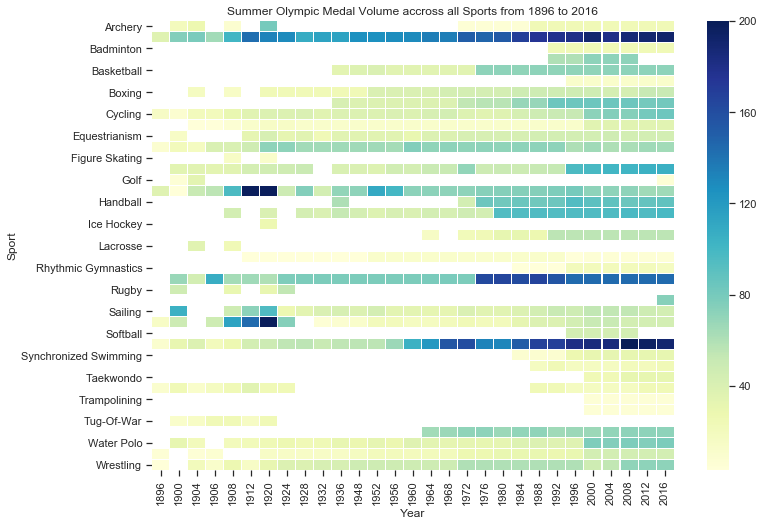

In [31]:
medals_data = df[(df.Medal != 'No Medal') & (df.Season != 'Winter')]
all_medals = medals_data.groupby(['Sport', 'Year'])['Medal'].count()


medal_count = all_medals.values
medals_by_sport = medals_data[['Sport', 'Year', 'Medal']].groupby(['Sport', 'Year'])['Medal'].count()
mdf = medals_by_sport.reset_index()

mdf['Year'] = mdf['Year'].astype(int)

sns.heatmap(mdf.pivot("Sport", "Year", "Medal"),linewidths=.02, cmap="YlGnBu")
plt.title("Summer Olympic Medal Volume accross all Sports from 1896 to 2016")

Above we have a heat map of all our olympic `Sport` categories that take place in the summer games. On the far right of the graph, we have the amount of medals regardless of the level of medal. The darker the color, the more medals received. The lighter the color, the less medals received. It is also important to understand that the grey areas do not indicate that no medals have been awarded in those sports, it just simply indicates that the volume of medals received was not enough to color the chart. With respect to time, we can see that medals started to become more common for the athletes the closer we get to the 2000's as more sport categories are represented by all the colors on the heat map.

## Explore Attributes and Class
---
The full data set has ben explored, but we will use podium finishers -- finishing in top 3 of an event -- as the response variable and we're going to predict this using cross-validation against the test and train data sets. Accuracy will determine how well the prediction algorithm is performing. Before building a prediction model, we will compare the response variable to other columns in the data set and explore the relationships. We will explore `age`, `height`, and `weight` and their relationship to podium finishes and medal type.

We first explore medal distribution across `age`, `height`, and `weight` with a pairplot. In this visualization, we see a normal medal type distribution for `age` for those who won medals and those who did not. Variations can be seen for `height` and `weight` where non-medal winning Olympians do not follow the distributions as closely as their medal-winning peers. Many outliers can be found among the non-podium finishers, but there are very few outliers among the podium finishers.

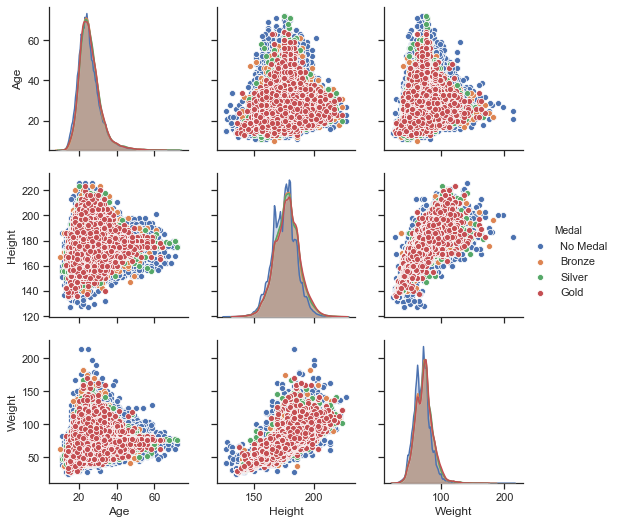

In [32]:
sns.pairplot(df, vars=['Age', 'Height', 'Weight'], hue='Medal', height = 2.5)

Next, we will look at `age` and the podium finishes:

Text(0.5, 1.0, 'Age vs Podium Finishes')

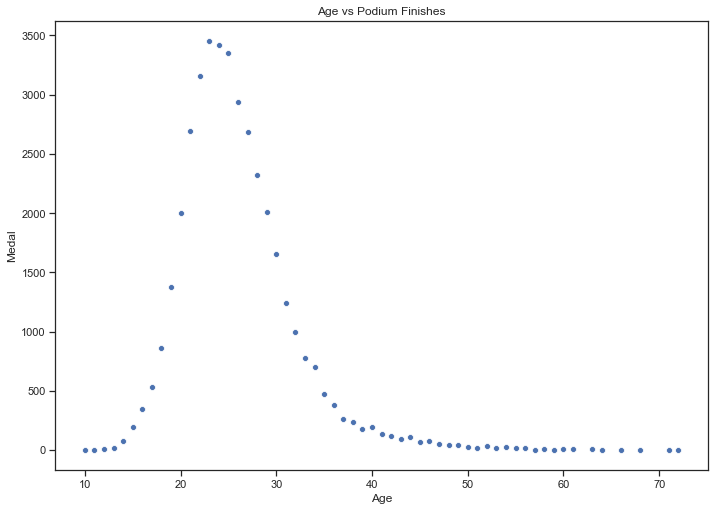

In [33]:
age_info = df[df['Medal'] != 'No Medal'].groupby(['Age'])['Medal'].count().sort_values(ascending=False)
age_df = pd.DataFrame({'Age': age_info.index, 'Medal': age_info.values })
sns.scatterplot(x="Age", y="Medal", data=age_df)
plt.title("Age vs Podium Finishes")

The distribution is right-tailed and as expected the peak medals are awarded between the `ages` of 20 and 30-years-old. Next we will perform a similar analysis with `height`:

Text(0.5, 1.0, 'Height vs Podium Finish')

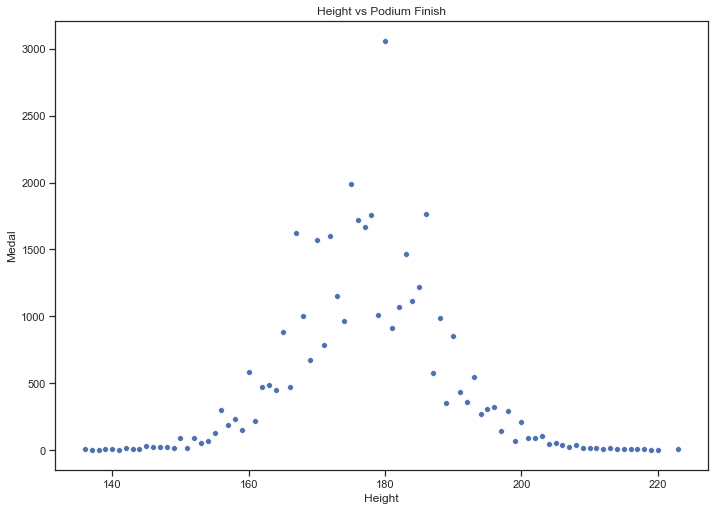

In [34]:
height_info = df[df['Medal'] != 'No Medal'].groupby(['Height'])['Medal'].count().sort_values(ascending=False)
height_df = pd.DataFrame({'Height': height_info.index, 'Medal': height_info.values })
sns.scatterplot(x="Height", y="Medal", data=height_df)
plt.title("Height vs Podium Finish")

The distribution is normal and the medal counts peak just under 180cm in `height` which is just under 6-feet tall. Next we will perform a similar analysis with `weight`:

Text(0.5, 1.0, 'Weight vs Podium Finish')

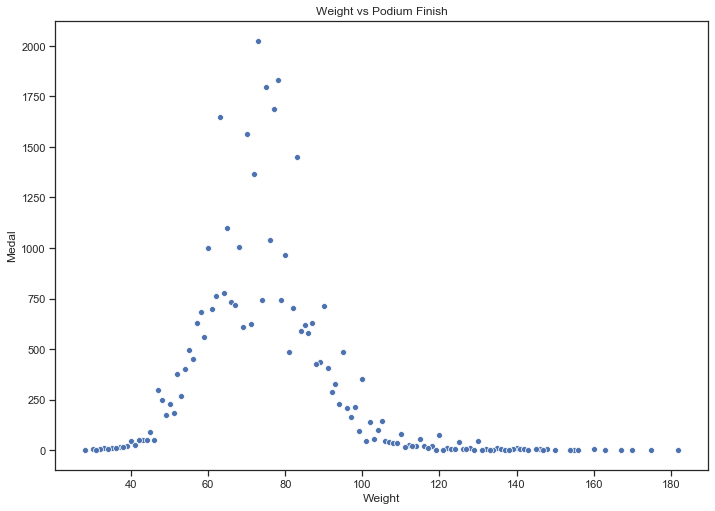

In [35]:
weight_info = df[df['Medal'] != 'No Medal'].groupby(['Weight'])['Medal'].count().sort_values(ascending=False)
weight_df = pd.DataFrame({'Weight': weight_info.index, 'Medal': weight_info.values })
sns.scatterplot(x="Weight", y="Medal", data=weight_df)
plt.title("Weight vs Podium Finish")

The distribution is right-tailed and the medal counts that appear to be zero are non-integer `weights` where the podium finisher count is <10. 

We observed nearly normal distributions for `age`, `height`, and `weight` in podium finishes and previously explored the relationship between `sport` and `country` on podium finishes. These variables may impact performance among Olympic athletes; not Plain Jane's and Average Joe's.

## New Features
---
The data set is somewhat limited in features, so feature engineering or bringing in additional features from outside of this particular data set could be beneficial. For example, individual-specific data is limited to `age`, `sex`, `weight`, and `height`. Bringing in additional performance indicators could potentially help predict podium finishes or help with trend analysis:
* `BMI` (created above)
* `Olympic Best`
* `Personal Best`
* `Body Fat %`
* `Repeat Olympian`
* `Previous Podium`

Bringing in additional country of origin indicators could potentially be helpful as well:
* `GDP per Capita`
* `Population`

## Exceptional Work
---

For exceptional work, we wanted to leverage the visualizations available in Tableau and add them to our notebook file. The question we attempted to answer with this visualization is whether or not there is a correlation between the maximum `height` and `weight` found in a country's athletes and that country's ability to win Olympic medals.

In [36]:
#Create dataframe of Total Medal Counts by Country
grouped = df.groupby(['Country', 'Medal']).size().to_frame(name = 'count').reset_index()
groupedpivot = grouped.pivot_table(index = 'Country', columns = 'Medal')
groupedpivot.fillna(0, inplace = True)
#print(groupedpivot.head())
grouped2 = df.groupby(['Country'])
#Create dataframe of Max Weight by Country
groupedweight = grouped2['Weight']
groupedweight = pd.DataFrame(groupedweight.agg('max'))
#print(groupedweight.head())
#Create dataframe of Max Height by Country
grouped1 = df.groupby(['Country'])
groupedheight = grouped1['Height']
groupedheight = pd.DataFrame(groupedheight.agg('max'))
#print(groupedheight.head())
grouped4 = pd.merge(left = groupedpivot, right = groupedweight, on = ['Country'], left_index = True)
grouped5 = pd.merge(left = grouped4, right = groupedheight, on = ['Country'], left_index = True)
#Send to Excel for import into Tableau
grouped5.to_excel('data/MedalCounts.xls')

In [37]:
%%HTML
<div class='tableauPlaceholder' id='viz1537022784522' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ol&#47;Olympics_191&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Olympics_191&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ol&#47;Olympics_191&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1537022784522');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

If you click a Country in the **MedalsTop20** barchart above, the dashboard will automatically filter the **WeightTop20** and **HeightTop20** barcharts to show the individual country.  The GEO map above will also filter down to the selected country and display the total number of Medals won, along with the total numbers of Gold, Silver, and Bronze Medals. 13 of the 20 (65%) Top 20 Medal winning Countries appear on at least one of the Top 20 Height or Top 20 Weight charts.  7 out of the Top 10 Medal winning countries also appear on the Top 20 Height bar chart.  It is clear that countries with taller and heavier athletes do possess a sizable advantage when it comes to winning Olympic Medals.